<center><font size="4"><span style="color:blue">Demonstration 1: general presentation with some quantities and statistics</span></font></center>

This is a general presentation of the 3W dataset, to the best of its authors' knowledge, the first realistic and public dataset with rare undesirable real events in oil wells that can be readily used as a benchmark dataset for development of machine learning techniques related to inherent difficulties of actual data.

For more information about the theory behind this dataset, refer to the paper **A Realistic and Public Dataset with Rare Undesirable Real Events in Oil Wells** published in the **Journal of Petroleum Science and Engineering**.

# 1. Introduction

This notebook presents the 3W dataset in a general way. For this, some tables, graphs, and statistics are presented.

# 2. Imports and Configurations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from pathlib import Path
from multiprocessing.dummy import Pool as ThreadPool
from collections import defaultdict
from natsort import natsorted

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
data_path = Path('.', 'data')
events_names = {0: 'Normal',
                1: 'Abrupt Increase of BSW',
                2: 'Spurious Closure of DHSV',
                3: 'Severe Slugging',
                4: 'Flow Instability',
                5: 'Rapid Productivity Loss',
                6: 'Quick Restriction in PCK',
                7: 'Scaling in PCK',
                8: 'Hydrate in Production Line'
               }
columns = ['P-PDG',
           'P-TPT',
           'T-TPT',
           'P-MON-CKP',
           'T-JUS-CKP',
           'P-JUS-CKGL',
           'T-JUS-CKGL',
           'QGL',
           'class']
rare_threshold = 0.01

# 3. Quantities of Instances

The following table shows the quantities of instances that compose the 3W dataset, by type of event and by knowledge source: real, simulated and hand-drawn instances.

In [4]:
def class_and_file_generator(data_path, real=False, simulated=False, drawn=False):
    for class_path in data_path.iterdir():
        if class_path.is_dir():
            class_code = int(class_path.stem)
            for instance_path in class_path.iterdir():
                if (instance_path.suffix == '.csv'):
                    if (simulated and instance_path.stem.startswith('SIMULATED')) or \
                       (drawn and instance_path.stem.startswith('DRAWN')) or \
                       (real and (not instance_path.stem.startswith('SIMULATED')) and \
                       (not instance_path.stem.startswith('DRAWN'))):
                        yield class_code, instance_path

In [5]:
real_instances = list(class_and_file_generator(data_path, real=True, simulated=False, drawn=False))
simulated_instances = list(class_and_file_generator(data_path, real=False, simulated=True, drawn=False))
drawn_instances = list(class_and_file_generator(data_path, real=False, simulated=False, drawn=True))

In [20]:
instances_class = [{'TYPE OF EVENT': str(c) + ' - ' + events_names[c], 'SOURCE': 'REAL'} for c, p in real_instances] + \
                  [{'TYPE OF EVENT': str(c) + ' - ' + events_names[c], 'SOURCE': 'SIMULATED'} for c, p in simulated_instances] + \
                  [{'TYPE OF EVENT': str(c) + ' - ' + events_names[c], 'SOURCE': 'DRAWN'} for c, p in drawn_instances]
df_class = pd.DataFrame(instances_class)
df_class_count = df_class.groupby(['TYPE OF EVENT', 'SOURCE']).size().reset_index().pivot('SOURCE', 'TYPE OF EVENT', 0).fillna(0).astype(int).T
df_class_count = df_class_count.loc[natsorted(df_class_count.index.values)]
df_class_count = df_class_count[['REAL', 'SIMULATED', 'DRAWN']]
df_class_count['TOTAL'] = df_class_count.sum(axis=1)
df_class_count.loc['TOTAL'] = df_class_count.sum(axis=0)
df_class_count

SOURCE,REAL,SIMULATED,DRAWN,TOTAL
TYPE OF EVENT,,,,
0 - Normal,597,0,0,597
1 - Abrupt Increase of BSW,5,114,10,129
2 - Spurious Closure of DHSV,22,16,0,38
3 - Severe Slugging,32,74,0,106
4 - Flow Instability,344,0,0,344
5 - Rapid Productivity Loss,12,439,0,451
6 - Quick Restriction in PCK,6,215,0,221
7 - Scaling in PCK,4,0,10,14
8 - Hydrate in Production Line,3,81,0,84


# 4. Rare Undesirable Events

When considering only **real instances** and threshold of 1%, the following types of events are rare.

In [21]:
th = rare_threshold*df_class_count['REAL'][-1]
df_class_count.loc[df_class_count['REAL'] < th]

SOURCE,REAL,SIMULATED,DRAWN,TOTAL
TYPE OF EVENT,,,,
1 - Abrupt Increase of BSW,5,114,10,129
6 - Quick Restriction in PCK,6,215,0,221
7 - Scaling in PCK,4,0,10,14
8 - Hydrate in Production Line,3,81,0,84


If **simulated instances** are also considered, the types of rare events become the ones listed below.

In [22]:
th = rare_threshold*(df_class_count['REAL'][-1]+df_class_count['SIMULATED'][-1])
df_class_count.loc[df_class_count['REAL']+df_class_count['SIMULATED'] < th]

SOURCE,REAL,SIMULATED,DRAWN,TOTAL
TYPE OF EVENT,,,,
7 - Scaling in PCK,4,0,10,14


After also considering the **hand-drawn instances**, we get the final list with rare types of events.

In [23]:
th = rare_threshold*(df_class_count['REAL'][-1]+df_class_count['SIMULATED'][-1]+df_class_count['DRAWN'][-1])
df_class_count.loc[df_class_count['REAL']+df_class_count['SIMULATED']+df_class_count['DRAWN'] < th]

SOURCE,REAL,SIMULATED,DRAWN,TOTAL
TYPE OF EVENT,,,,
7 - Scaling in PCK,4,0,10,14


# 5. Scatter Map of Real Instances

A scatter map with all the **real instances** is shown below. The oldest one occurred in the middle of 2012 and the most recent one in the middle of 2018. In addition to the total number of considered wells, this map provides an overview of the occurrences distributions of each undesirable event over time and between wells.

In [28]:
def load_instance(instances):
    class_code, instance_path = instances
    try:
        well, instance_id = instance_path.stem.split('_')
        df = pd.read_csv(instance_path, index_col='timestamp', parse_dates=['timestamp'])
        assert (df.columns == columns).all(), "invalid columns in the file {}: {}".format(str(instance_path), str(df.columns.tolist()))
        df['class_code'] = class_code
        df['well'] = well
        df['instance_id'] = instance_id
        df = df[['class_code', 'well', 'instance_id'] + columns]
        return df
    except Exception as e:
        raise Exception('error reading file {}: {}'.format(instance_path, e))

In [29]:
def load_instances(instances):
    pool = ThreadPool()
    all_df = []
    try:
        for df in pool.imap_unordered(load_instance, instances):
            all_df.append(df)
    finally:
        pool.terminate()
    df_all = pd.concat(all_df)
    del all_df
    return df_all

In [30]:
df_real = load_instances(real_instances)
df_time = df_real.reset_index().groupby(['well', 'instance_id', 'class_code'])['timestamp'].agg(['min', 'max'])

In [31]:
well_times = defaultdict(list)
well_classes = defaultdict(list)
for (well, instance_id, class_code), (tmin, tmax) in df_time.iterrows():
    well_times[well].append((tmin.toordinal(), (tmax.toordinal() - tmin.toordinal())))
    well_classes[well].append(int(class_code))

In [32]:
wells = df_real['well'].unique()
well_code = {w:i for i, w in enumerate(sorted(wells))}

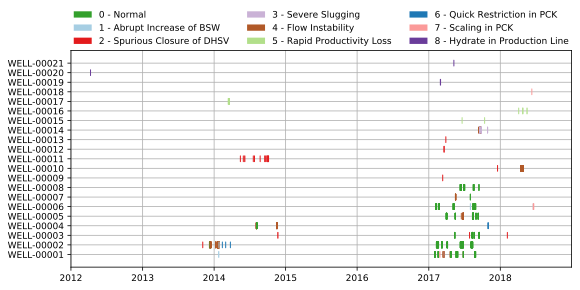

In [33]:
cmap = plt.get_cmap('Paired')
my_colors = [cmap(i) for i in [3, 0, 5, 8, 11, 2, 1, 4, 9, 7, 6, 10]]
my_cmap = mcolors.ListedColormap(my_colors, name='my_cmap')
plt.register_cmap(name='my_cmap', cmap=my_cmap)
cmap = plt.get_cmap('my_cmap')
height = 5
border = 2
first_year = np.min(df_time['min']).year
last_year = np.max(df_time['max']).year
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['font.size'] = 9
plt.rcParams['legend.fontsize'] = 9
fig, ax = plt.subplots(figsize=(9, 4))
yticks = []
yticks_labels = []
for well in well_times.keys():
    times = well_times[well]
    class_names = well_classes[well]    
    class_colors = list(map(cmap, class_names))
    well_id = well_code[well]
    yticks.append(well_id * height + height/2 - border/2)
    yticks_labels.append(well)
    ax.broken_barh(times, (well_id * height, height - border), facecolors=class_colors, edgecolors=class_colors)
ax.grid(True)
ax.set_axisbelow(True)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks_labels)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_xlim(pd.datetime(first_year, 1, 1).toordinal(), pd.datetime(last_year, 12, 31).toordinal())
legend_colors = [Patch(facecolor=cmap(i), label=str(i) + ' - ' + events_name) for i, events_name in events_names.items()]
ax.legend(frameon=False, handles=legend_colors, loc='upper center', bbox_to_anchor=(0.5, 1.22), ncol=3);
#fig.savefig('figure.pdf', dpi=500, bbox_inches='tight')

# 6. Some Statistics

The main 3W dataset's fundamental aspects related to inherent difficulties of actual data are presented next.

In [30]:
def calc_stats_instance(instances):
    _, instance_path = instances
    n_vars_missing = 0
    n_vars_frozen = 0
    try:    
        df = pd.read_csv(instance_path, index_col='timestamp', parse_dates=['timestamp'])
        vars = df.columns[:-1]
        n_vars = len(vars)
        for var in vars:
            if df[var].isnull().all(): 
                n_vars_missing += 1
            u_values = df[var].unique()
            if len(u_values) == 1 and not np.isnan(u_values):
                n_vars_frozen += 1
        n_obs = len(df)
        n_obs_unlabeled = df['class'].isnull().sum()
        return pd.DataFrame({'n_vars':[n_vars], 
                             'n_vars_missing':[n_vars_missing],
                             'n_vars_frozen':[n_vars_frozen],
                             'n_obs':[n_obs],
                             'n_obs_unlabeled':[n_obs_unlabeled]
                            })
    except Exception as e:
        raise Exception('error reading file {}: {}'.format(instance_path, e))

In [31]:
def calc_stats_instances(instances):
    pool = ThreadPool()
    all_stats = []
    try:
        for stats in pool.imap_unordered(calc_stats_instance, instances):
            all_stats.append(stats)
    finally:
        pool.terminate()
    df_all_stats = pd.concat(all_stats)
    del all_stats
    return df_all_stats.sum()

In [32]:
global_stats = calc_stats_instances(real_instances+simulated_instances+drawn_instances)

In [33]:
print('missing variables: {} of {} ({:.2f}%)'.format(global_stats['n_vars_missing'], global_stats['n_vars'], 100*global_stats['n_vars_missing']/global_stats['n_vars']))
print('frozen variables: {} of {} ({:.2f}%)'.format(global_stats['n_vars_frozen'], global_stats['n_vars'], 100*global_stats['n_vars_frozen']/global_stats['n_vars']))
print('unlabeled observations: {} of {} ({:.2f}%)'.format(global_stats['n_obs_unlabeled'], global_stats['n_obs'], 100*global_stats['n_obs_unlabeled']/global_stats['n_obs']))

missing variables: 4947 of 15872 (31.17%)
frozen variables: 1535 of 15872 (9.67%)
unlabeled observations: 5130 of 50913215 (0.01%)
